In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import yaml
from base64 import b64encode

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)
        return yaml.dump(yaml_content, default_flow_style=False)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return b64encode(image_file.read()).decode('utf-8')

app_strings = read_yaml_file('save_file.yaml')
screenshot = encode_image('save_file.png')

In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import operator
import os
from langchain_openai import ChatOpenAI

class State(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  translation_count: int
  translation: str
  contextualized: str
  advice: str

llm = ChatOpenAI(
  api_key=os.getenv("OPENAI_API_KEY"),
  model="gpt-4o"
)

In [4]:
def contextualize(state):
  print("contextualizing")
  prompt = """You are an expert in mobile app string localization and internationalization.
  You are preparing app strings to be localized in another language by 
  providing additional context in English to help the translator. 
  Add comments to each line of the following text based on what you see in the image. 
  Use YAML style comments and put them on the line above the text being commented."""
  user = HumanMessage(content=[
    {"type": "text", "text": prompt},
    {"type": "text", "text": app_strings},
    {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/png;base64,{screenshot}"
      }
    }
  ])
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], "contextualized": response.content}

In [5]:
def translate(state):
  print("translating")
  given_text = state["contextualized"]
  prompt = f"""You are a world-class translator. Translate the given text from English to Spanish. 
  Each line is commented and you should take those comments into consideration in order 
  to get an accurate translation. Don't translate the comments or the keys.
  Given text: 
  {given_text}
  
  """
  advice = state["advice"]
  if advice:
      prompt = prompt + f"Here is some advice to follow when translating: {advice}"
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], 
    "translation_count": state["translation_count"] + 1,
    "translation": response.content
  }

In [6]:
def check(state):
  print("checking")
  translation = state["translation"]
  prompt = f"""You are an expert in mobile app UI/UX and also cross-cultural communication.
  A translator has submitted a translation for the strings of a UI layout.
  Check the translation for accuracy. If the translation is good, reply with one 
  word: "done". If not, provide some helpful advice for improving the translation.
  Just use a bulleted list of points to pay attention to.
  Here is the original text:
  {app_strings}
  Here is the translation with contextual comments:
  {translation}
  The YAML comments and keys didn't need to be translated.
  """
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response], "advice": response.content}

In [8]:
def should_stop_translating(state):
  translation_count = state["translation_count"]
  if translation_count > 2:
    return True
  ai_response = state["messages"][-1].content.lower()
  return ai_response == "done"

In [9]:
def format_translation(state):
  print("formatting")
  translation = state["translation"]
  prompt = f"""Clean this YAML text up by removing any comments. Don't make any comments:
  {translation}
  """
  user = HumanMessage(content=prompt)
  state["messages"].append(user)
  response = llm.invoke([user])
  return {"messages": [response]}

In [10]:
graph = StateGraph(State)

graph.add_node("contextualizer", contextualize)
graph.add_edge(START, "contextualizer")

graph.add_node("translator", translate)
graph.add_edge("contextualizer", "translator")

graph.add_node("checker", check)
graph.add_edge("translator", "checker")

graph.add_node("formatter", format_translation)
graph.add_conditional_edges(
  "checker", 
  should_stop_translating,
  {
    True: "formatter", 
    False: "translator"
  }
)
graph.add_edge("formatter", END)

app = graph.compile()

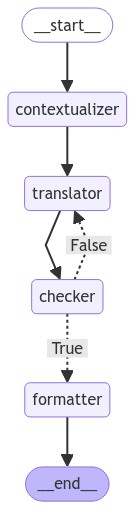

In [11]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

contextualizing
translating
checking
formatting
```yaml
message: ¿Le gustaría guardar el archivo?
negative_button: Descartar
positive_button: Guardar
title: Pregunta
```
{'messages': [HumanMessage(content=[{'type': 'text', 'text': 'You are an expert in mobile app string localization and internationalization.\n  You are preparing app strings to be localized in another language by \n  providing additional context in English to help the translator. \n  Add comments to each line of the following text based on what you see in the image. \n  Use YAML style comments and put them on the line above the text being commented.'}, {'type': 'text', 'text': 'message: Would you like to save the file?\nnegative_button: Discard\npositive_button: Save\ntitle: Question\n'}, {'type': 'image_url', 'image_url': {'url': ''}}]), AIMessage(content='```yaml\n# The message asking the user if they want to save the current file.\nmessage: Would you like to save the file?\n\n# The text for the button which discards 
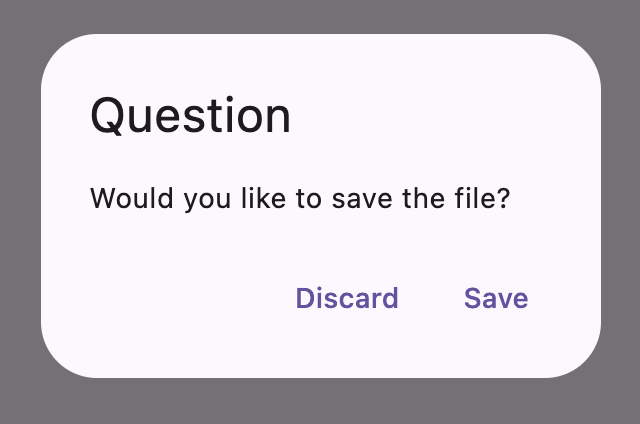

In [12]:
state = State(
  messages=[],
  translation_count=0,
  contextualized="",
  translation="",
  advice=""
)
response = app.invoke(state)
print(response['messages'][-1].content)
print(response)